In [1]:
import numpy as np
import pandas as pd
import util.util as util
import random
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [2]:
data_path = "data/toy_dataset.csv"
df = pd.read_csv(data_path, na_values='?')

In [4]:
# missingness_rates = np.linspace(0.1, 1, 10)
# 
# for miss_rate in missingness_rates:
#     df_with_missing = util.introduce_missingness(df, miss_rate)
#     print(f'Missing Rate: {miss_rate}')
#     print(df_with_missing.head())

{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

In [8]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

class ImputationEnvironment:
    def __init__(self, incomplete_data, complete_data):
        self.incomplete_data = incomplete_data
        self.complete_data = complete_data
        self.state = incomplete_data.copy()
        self.missing_indices = np.argwhere(pd.isna(incomplete_data.values))
        
    def reset(self):
        self.state = self.incomplete_data.copy()
        return self.state

    def step(self, action, position):
        row, col = position
        self.state.iat[row, col] = action

        reward = -abs(self.complete_data.iat[row, col] - action)
        done = not pd.isna(self.state.values).any()
        return self.state, reward, done

    def get_possible_actions(self, col):
        # Ensure col is an integer if it's a numpy int
        if isinstance(col, np.int64):
            col = int(col)

        if isinstance(col, int):
            if 0 <= col < len(self.complete_data.columns):
                col_name = self.complete_data.columns[col]
            else:
                raise KeyError(f"Column index {col} out of range")
        elif isinstance(col, str):
            if col in self.complete_data.columns:
                col_name = col
            else:
                raise KeyError(f"Column name '{col}' not found in DataFrame")
        else:
            raise TypeError("Column must be either an integer index or a string column name")

        return self.complete_data[col_name].dropna().unique()

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: defaultdict(float))

    def choose_action(self, state, position):
        state_key = (tuple(state.values.flatten()), tuple(position))
        
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.env.get_possible_actions(position[1]))
        else:
            col = position[1]
            actions = self.env.get_possible_actions(col)
            q_values = {a: self.q_table[state_key][a] for a in actions}
            return max(q_values, key=q_values.get)

    def learn(self, state, action, reward, next_state, position):
        state_key = (tuple(state.values.flatten()), tuple(position))
        next_state_key = (tuple(next_state.values.flatten()), tuple(position))

        q_predict = self.q_table[state_key][action]
        q_target = reward + self.gamma * max(self.q_table[next_state_key].values(), default=0)
        self.q_table[state_key][action] += self.alpha * (q_target - q_predict)

    def train(self, episodes=1):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                position = random.choice(self.env.missing_indices)
                action = self.choose_action(state, position)
                next_state, reward, done = self.env.step(action, position)
                self.learn(state, action, reward, next_state, position)
                state = next_state

In [9]:
# Load data and train the agent
incomplete_data_path = 'data/toy_dataset_missing.csv'
complete_data_path = 'data/toy_dataset.csv'

incomplete_data = pd.read_csv(incomplete_data_path)
complete_data = pd.read_csv(complete_data_path)

incomplete_data.replace("?", np.nan, inplace=True)
complete_data.replace("?", np.nan, inplace=True) # we shouldn't really have missing data here but wtvr

In [10]:
print(complete_data.columns)

Index(['Col 1', 'Col 2', 'Col 3', 'Col 4'], dtype='object')


In [11]:
#Optional: Scale the data
scaler = MinMaxScaler()
incomplete_data = pd.DataFrame(scaler.fit_transform(incomplete_data), columns=incomplete_data.columns)
complete_data = pd.DataFrame(scaler.transform(complete_data), columns=complete_data.columns)

env = ImputationEnvironment(incomplete_data, complete_data)
agent = QLearningAgent(env)

agent.train(episodes=1)

In [ ]:
# # Example calls
# col_index = 3  # Example of integer index
# col_name = 'Col 4'  # Example of column name

# actions_by_index = env.get_possible_actions(col_index)
# actions_by_name = env.get_possible_actions(col_name)
# print(actions_by_index)
# print(actions_by_name)

In [9]:
# Imputed data
qlearning_imputed_data = agent.env.state
print(qlearning_imputed_data)

   Col 1  Col 2  Col 3  Col 4
0   0.17   0.26   0.57   1.00
1   0.50   0.53   0.00   0.83
2   0.83   0.00   0.57   0.83
3   0.17   0.26   0.87   0.50
4   1.00   0.53   0.57   0.67
5   0.50   0.84   0.86   0.00
6   0.85   0.26   0.17   0.83
7   0.03   1.00   0.71   1.00
8   0.17   0.13   0.86   0.83
9   0.00   0.26   1.00   0.70


In [4]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import time
import logging
from collections import deque
from sklearn.preprocessing import MinMaxScaler

class ImputationEnvironment:
    def __init__(self, incomplete_data, complete_data):
        self.incomplete_data = incomplete_data
        self.complete_data = complete_data
        self.state = incomplete_data.copy()
        self.missing_indices = np.argwhere(pd.isna(incomplete_data.values))

    def reset(self):
        self.state = self.incomplete_data.copy()
        return self.state

    def step(self, action, position):
        row, col = position
        self.state.iat[row, col] = action

        reward = -abs(self.complete_data.iat[row, col] - action)
        done = not pd.isna(self.state.values).any()
        return self.state, reward, done

    def get_possible_actions(self, col):
        col = int(col)
        if 0 <= col < len(self.complete_data.columns):
            col_name = self.complete_data.columns[col]
        else:
            raise KeyError(f"Column index {col} out of range")

        return self.complete_data[col_name].dropna().unique()

class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.95, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995, learning_rate=0.001, batch_size=32, memory_size=2000):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.model = self._build_model()

    def _build_model(self):
        hidden_size = 24
        model = nn.Sequential(
            nn.Linear(self.state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_size)  # Output one Q-value per action
        )
        return model

    def remember(self, state, action_index, reward, next_state, done, position_col_index):
        self.memory.append((state, action_index, reward, next_state, done, position_col_index))

    def act(self, state, position_col_index):
        possible_actions = env.get_possible_actions(position_col_index)
        if np.random.rand() <= self.epsilon:
            action_index = random.randrange(len(possible_actions))
        else:
            state_tensor = torch.FloatTensor(state)
            q_values = self.model(state_tensor)
            action_index = torch.argmax(q_values).item()
        return action_index, possible_actions[action_index]

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        for state, action_index, reward, next_state, done, position_col_index in minibatch:
            target = reward
            if not done:
                next_state_tensor = torch.FloatTensor(next_state)
                possible_next_actions = env.get_possible_actions(position_col_index)
                next_q_values = self.model(next_state_tensor)
                target = reward + self.gamma * torch.max(next_q_values).item()
            
            target_f = self.model(torch.FloatTensor(state))
            target_value = target_f.clone().detach()
            target_value[action_index] = target
            loss = criterion(target_f, target_value)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Load data
incomplete_data = pd.read_csv('data/toy_dataset_missing.csv')
complete_data = pd.read_csv('data/toy_dataset.csv')

incomplete_data.replace("?", np.nan, inplace=True)
complete_data.replace("?", np.nan, inplace=True)

scaler = MinMaxScaler()
incomplete_data = pd.DataFrame(scaler.fit_transform(incomplete_data), columns=incomplete_data.columns)
complete_data = pd.DataFrame(scaler.transform(complete_data), columns=complete_data.columns)

# Setup environment and agent
env = ImputationEnvironment(incomplete_data, complete_data)
state_size = incomplete_data.size  # Use total size if flattening entire data

# Assuming the maximum number of possible actions based on the column with the most unique values
action_size = max(len(env.get_possible_actions(col)) for col in range(incomplete_data.shape[1]))

agent = DQNAgent(state_size=state_size, action_size=action_size)

# Train the agent
EPISODES = 800000
progress_interval = 1  # How often to log progress
start_time = time.time()

for e in range(EPISODES):
    state = env.reset()
    state = state.values.flatten()
    done = False
    while not done:
        position = random.choice(env.missing_indices)
        position_col_index = position[1]  # Column index
        action_index, action_value = agent.act(state, position_col_index)
        next_state, reward, done = env.step(action_value, position)
        next_state = next_state.values.flatten()
        agent.remember(state, action_index, reward, next_state, done, position_col_index)
        state = next_state
    agent.replay()
    
     # Log progress every 'progress_interval' episodes
    if (e + 1) % progress_interval == 0:
        elapsed_time = time.time() - start_time
        estimated_total_time = (elapsed_time / (e + 1)) * EPISODES
        estimated_remaining_time = estimated_total_time - elapsed_time

        logging.info(f"Episode {e + 1}/{EPISODES} completed.")
        logging.info(f"Elapsed Time: {elapsed_time:.2f}s, Estimated Total Time: {estimated_total_time:.2f}s, Estimated Remaining Time: {estimated_remaining_time:.2f}s")
# Save the trained model
agent.save("dqn_model.pth")

# Print the imputed data
dqlearning_imputed_data = env.state

KeyboardInterrupt: 

In [1]:
print(dqlearning_imputed_data)

actual_data = complete_data  # Assuming this is the complete data loaded earlier


NameError: name 'dqlearning_imputed_data' is not defined

In [12]:
print("Q-Learning Agent Imputed Data")
mae, rmse = util.calculate_errors(qlearning_imputed_data, actual_data)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

Q-Learning Agent Imputed Data
Mean Absolute Error (MAE): 0.04825
Root Mean Square Error (RMSE): 0.1388074205509201


In [13]:
print("DQNAgent Imputed Data")
mae,rmse = util.calculate_errors(dqlearning_imputed_data, actual_data)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Square Error (RMSE): {rmse}")

DQNAgent Imputed Data
Mean Absolute Error (MAE): 0.05225
Root Mean Square Error (RMSE): 0.15542683166043111


In [7]:
import numpy as np
import pandas as pd
import random
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

class ImputationEnvironment:
    def __init__(self, incomplete_data, complete_data):
        self.incomplete_data = incomplete_data
        self.complete_data = complete_data
        self.state = incomplete_data.copy()
        self.missing_indices = np.argwhere(pd.isna(incomplete_data.values))

    def reset(self):
        """Reset the environment state to the initial incomplete data."""
        self.state = self.incomplete_data.copy()
        return self.state

    def step(self, action, position):
        """Take an action to impute a missing value at the given position."""
        row, col = position
        self.state.iat[row, col] = action

        # Reward is the negative absolute error
        reward = -abs(self.complete_data.iat[row, col] - action)
        done = not pd.isna(self.state.values).any()  # Check if all values are imputed
        return self.state, reward, done

    def get_possible_actions(self, col):
        """Get unique possible values for a column."""
        col = int(col)  # Ensure col is an integer
        if 0 <= col < len(self.complete_data.columns):
            col_name = self.complete_data.columns[col]
        else:
            raise KeyError(f"Column index {col} out of range")

        return self.complete_data[col_name].dropna().unique()

class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: defaultdict(float))

    def choose_action(self, state, position):
        """Choose an action using an epsilon-greedy policy."""
        state_key = (tuple(state.values.flatten()), tuple(position))

        if random.uniform(0, 1) < self.epsilon:
            # Exploration: choose a random action
            return random.choice(self.env.get_possible_actions(position[1]))
        else:
            # Exploitation: choose the best known action
            col = position[1]
            actions = self.env.get_possible_actions(col)
            q_values = {a: self.q_table[state_key][a] for a in actions}
            return max(q_values, key=q_values.get)

    def learn(self, state, action, reward, next_state, position):
        """Update the Q-table based on the action taken."""
        state_key = (tuple(state.values.flatten()), tuple(position))
        next_state_key = (tuple(next_state.values.flatten()), tuple(position))

        q_predict = self.q_table[state_key][action]
        q_target = reward + self.gamma * max(self.q_table[next_state_key].values(), default=0)
        self.q_table[state_key][action] += self.alpha * (q_target - q_predict)

    def train(self, episodes=1000):
        """Train the agent over a number of episodes."""
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            while not done:
                position = random.choice(self.env.missing_indices)
                action = self.choose_action(state, position)
                next_state, reward, done = self.env.step(action, position)
                self.learn(state, action, reward, next_state, position)
                state = next_state

# Load data and train the agent
incomplete_data_path = 'data/toy_dataset_missing.csv'
complete_data_path = 'data/toy_dataset.csv'

incomplete_data = pd.read_csv(incomplete_data_path)
complete_data = pd.read_csv(complete_data_path)

incomplete_data.replace("?", np.nan, inplace=True)
complete_data.replace("?", np.nan, inplace=True)  # Ensure data is clean

# Optional: Scale the data
scaler = MinMaxScaler()
incomplete_data = pd.DataFrame(scaler.fit_transform(incomplete_data), columns=incomplete_data.columns)
complete_data = pd.DataFrame(scaler.transform(complete_data), columns=complete_data.columns)

env = ImputationEnvironment(incomplete_data, complete_data)
agent = QLearningAgent(env)

agent.train(episodes=1)

# Imputed data
imputed_data = env.state
print(imputed_data)

   Col 1  Col 2  Col 3  Col 4
0   0.17   0.26   0.57   1.00
1   0.50   0.53   0.00   0.83
2   0.83   0.00   0.57   1.00
3   0.17   0.26   0.87   0.50
4   1.00   0.53   0.57   0.67
5   0.17   0.84   0.86   0.00
6   0.85   0.26   0.17   0.83
7   0.03   1.00   0.71   1.00
8   0.17   0.13   0.86   0.83
9   0.00   0.26   1.00   0.70


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchrl.envs import EnvBase
from torchrl.agents import DQNAgent
from torchrl.experience import ReplayBuffer
from torchrl.train import Trainer

Using cuda device
Imputed value: 0.0 at row: 2, column: Col 4
Imputed value: 0.7777777777777778 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.2222222222222222 at row: 5, column: Col 1
Imputed value: 0.3333333333333333 at row: 6, column: Col 2
Imputed value: 0.6666666666666666 at row: 7, column: Col 4
Imputed value: 0.4444444444444444 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.7777777777777778 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.0 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.0 at row: 2, column: Col 4
Imputed value: 0.2222222222222222 at row: 3, column: Col 2
Imputed value: 0.1111111111111111 at row: 4, column: Col 3
Imputed value: 0.8888888888888888 at row: 5, column: Col 1
Imputed value: 0.5555555555555556 at row: 6, column: Col 2
Imputed value: 0.1111111

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-

Imputed value: 0.0 at row: 2, column: Col 4
Imputed value: 0.5555555555555556 at row: 3, column: Col 2
Imputed value: 0.1111111111111111 at row: 4, column: Col 3
Imputed value: 1.0 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.0 at row: 7, column: Col 4
Imputed value: 1.0 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.7777777777777778 at row: 5, column: Col 1
Imputed value: 0.8888888888888888 at row: 6, column: Col 2
Imputed value: 0.3333333333333333 at row: 7, column: Col 4
Imputed value: 0.4444444444444444 at row: 2, column: Col 4
Imputed value: 0.6666666666666666 at row: 3, column: Col 2
Imputed value: 0.5555555555555556 at row: 4, column: Col 3
Imputed value: 0.2222222222222222 at row: 5, column: Col 1
Imputed value: 0.1111111111111111 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.5555555555555556 at row: 2, column: Col 4
Imputed value: 0.5555555555555556 at row: 3, column: Col 2
Imputed value: 0.5555555555555556 at row: 4, column: Col 3
Imputed value: 0.5555555555555556 at row: 5, column: Col 1
Imputed value: 0.5555555555555556 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.5555555555555556 at row: 3, column: Col 2
Imputed value: 0.5555555555555556 at row: 4, column: Col 3
Imputed value: 0.5555555555555556 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.3333333333333333 at row: 7, column: Col 4
Imputed value: 0.5555555555555556 at row: 2, column: Col 4
Imputed value: 0.1111111111111111 at row: 3, column: Col 2
Imputed value: 0.5555555555555556 at row: 4, column: Col 3
Imputed value: 0.1111111111111111 at row: 5, column: Col 1
Imputed value: 0.1111111111111111 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.2222222222222222 at row: 3, column: Col 2
Imputed value: 0.8888888888888888 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.5555555555555556 at row: 6, column: Col 2
Imputed value: 0.8888888888888888 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 1.0 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.1111111111111111 at row: 5, column: Col 1
Imputed value: 0.8888888888888888 at row: 6, column: Col 2
Imputed value: 0.6666666666666666 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.2222222222222222 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.0 at row: 5, column: Col 1
Imputed value: 0.2222222222222222 at row: 6, column: Col 2
Imputed value: 0.6666666666

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.2222222222222222 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.6666666666666666 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.2222222222222222 at row: 6, column: Col 2
Imputed value: 0.3333333333333333 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 1.0 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.4444444444444444 at row: 5, column: Col 1
Imputed value: 0.5555555555555556 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.7777777777777778 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.8888888888888888 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.3333333333333333 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.7777777777777778 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.3333333333333333 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 1.0 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.4444444444444444 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.0 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.5555555555555556 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.0 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.2222222222222222 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.1111111111111111 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.6666666666666666 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 1.0 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.6666666666666666 at row: 5, column: Col 1
Imputed value: 0.6666666666666666 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.8888888888888888 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.2222222222222222 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 1.0 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.1111111111111111 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.2222222222222222 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.4444444444444444 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.0 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.5555555555555556 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.5555555555555556 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.3333333333333333 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.2222222222222222 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.5555555555555556 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.5555555555555556 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.7777777777777778 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.6666666666666666 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 1.0 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.0 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.8888888888888888 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.6666666666666666 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.6666666666666666 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.6666666666666666 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.1111111111111111 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.5555555555555556 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.4444444444444444 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.5555555555555556 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.7777777777777778 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.1111111111111111 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.8888888888888888 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 1.0 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.0 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.4444444444444444 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.2222222222222222 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.5555555555555556 at row: 7, column: Col 4
Imputed value: 0.4444444444444444 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.0 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.4444444444444444 at row: 6, column: Col 2
Imputed value: 0.4444444444444444 at row: 7, column: Col 4
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed value: 0.3333333333333333 at row: 3, column: Col 2
Imputed value: 0.2222222222222222 at row: 4, column: Col 3
Imputed value: 0.3333333333333333 at row: 5, column: Col 1
Imputed value: 0.3333333333333333 at row: 2, column: Col 4
Imputed valu

C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\educa\miniforge3\envs\rl-imputation\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\e

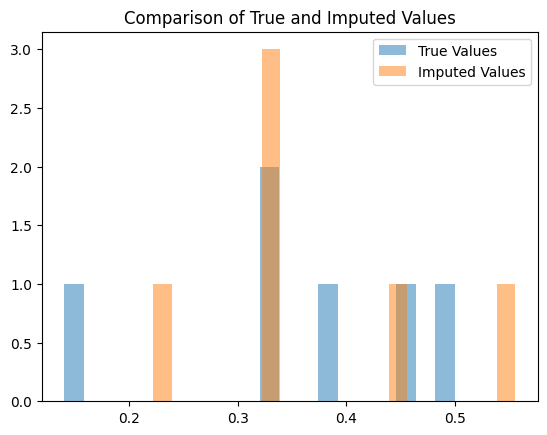

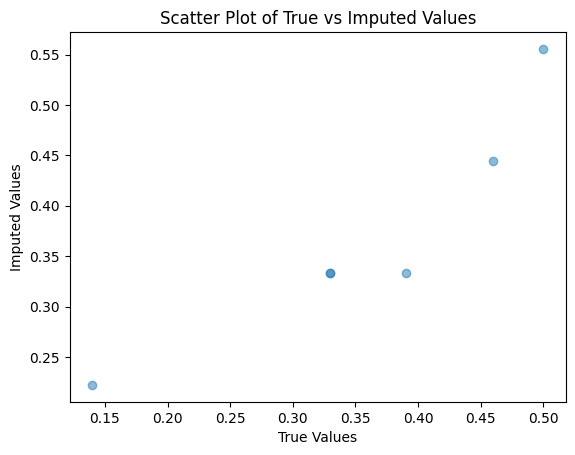

In [12]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

class ImputationEnv(gym.Env):
    def __init__(self, incomplete_data, complete_data):
        super(ImputationEnv, self).__init__()
        self.incomplete_data = incomplete_data.copy()
        self.complete_data = complete_data.copy()
        
        # Find the missing indices
        self.missing_indices = np.argwhere(pd.isnull(self.incomplete_data).values)
        self.current_index = 0

        # Check if there are missing values
        if len(self.missing_indices) == 0:
            raise ValueError("No missing values found in the dataset for imputation.")

        # Define the range of possible actions
        self.min_value = self.complete_data.min().min()
        self.max_value = self.complete_data.max().max()
        self.num_actions = 10  # Number of discrete actions

        # Define action and observation spaces
        self.observation_space = gym.spaces.Box(
            low=self.min_value, high=self.max_value, shape=(self.incomplete_data.shape[1],), dtype=np.float32
        )
        self.action_space = gym.spaces.Discrete(self.num_actions)

        # Create a scaler for normalization
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaler.fit(self.complete_data.fillna(0))

    def reset(self):
        self.current_index = 0
        return self._get_observation()

    def _get_observation(self):
        # Get the current row observation
        obs = self.incomplete_data.iloc[self.current_index].fillna(0).values
        obs = self.scaler.transform([obs])[0]
        return obs.astype(np.float32)

    def step(self, action):
        # Ensure current index is within bounds
        if self.current_index >= len(self.missing_indices):
            raise IndexError("Current index out of bounds in missing indices.")

        # Get the row and column index of the missing value
        row, col = self.missing_indices[self.current_index]

        # Map the action to a real value
        action_value = self.min_value + (action / (self.num_actions - 1)) * (self.max_value - self.min_value)
        predicted_value = action_value

        actual_value = self.complete_data.iloc[row, col]

        # Calculate reward based on accuracy of prediction
        reward = -abs(predicted_value - actual_value)  # Penalize based on the error

        # Apply the imputation
        self.incomplete_data.iloc[row, col] = predicted_value

        # Print the imputed value with row and column information
        print(f"Imputed value: {predicted_value} at row: {row}, column: {self.incomplete_data.columns[col]}")

        # Move to the next missing value
        self.current_index += 1
        done = self.current_index >= len(self.missing_indices)

        return self._get_observation(), reward, done, {}

    def render(self, mode='human'):
        pass

# Load your data
incomplete_data_path = 'data/toy_dataset_missing.csv'
complete_data_path = 'data/toy_dataset.csv'

# Read the CSV files into Pandas DataFrames
incomplete_data = pd.read_csv(incomplete_data_path)
complete_data = pd.read_csv(complete_data_path)
incomplete_data.replace("?", np.nan, inplace=True)
complete_data.replace("?", np.nan, inplace=True)  # Ensure data is clean

# Create the environment
env = ImputationEnv(incomplete_data, complete_data)
env = DummyVecEnv([lambda: env])  # Vectorize the environment

# Define the DQN model
model = DQN('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Evaluate the model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward: {mean_reward} +/- {std_reward}")

# Save the trained model
model.save('results/dqn_imputation_model')

# Access the imputed data
imputed_data = env.get_attr('incomplete_data')[0]

# Save the imputed data to a CSV file
imputed_data.to_csv('results/imputed_data.csv', index=False)

# Evaluate the imputation performance
original_missing = np.argwhere(pd.isnull(incomplete_data).values)
imputed_values = imputed_data.values[original_missing[:, 0], original_missing[:, 1]]
true_values = complete_data.values[original_missing[:, 0], original_missing[:, 1]]

# Calculate MAE and MSE
mae = mean_absolute_error(true_values, imputed_values)
mse = mean_squared_error(true_values, imputed_values)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Calculate the percentage of correct imputations
correct_imputations = np.sum(imputed_values == true_values)
total_missing = len(original_missing)
accuracy = correct_imputations / total_missing * 100
print(f"Accuracy of imputation: {accuracy:.2f}%")

# Visualize the results
plt.hist(true_values, bins=20, alpha=0.5, label='True Values')
plt.hist(imputed_values, bins=20, alpha=0.5, label='Imputed Values')
plt.legend(loc='upper right')
plt.title('Comparison of True and Imputed Values')
plt.show()

plt.scatter(true_values, imputed_values, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Imputed Values')
plt.title('Scatter Plot of True vs Imputed Values')
plt.show()


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Access the imputed data
imputed_data = env.get_attr('incomplete_data')[0]

# Save the imputed data to a CSV file
imputed_data.to_csv('results/imputed_data2.csv', index=False)